ARIMAX extends the traditional ARIMA by incorporating additional exogenous (external) variable

Insert necessary libraries

In [13]:
# Data manipulation
import pandas as pd
import numpy as np

# ARIMA model for time series forecasting
from statsmodels.tsa.arima.model import ARIMA
#Seasonal Arima model for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit

# Statistical modeling tools
import statsmodels.api as sm

# Metrics for model evaluation (MSE, R², accuracy, recall, precision)
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score

# Plotting for visualization
import matplotlib.pyplot as plt

# Grid search and warnings handling
import itertools
import warnings




Read file

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2011-2024completefinaldatasets.csv')
df.head()

Time  Rainfall  Temperature   Humidity  Cases
0  2011-w1  9.938571    29.444400  86.242857      5
1  2011-w2  8.587143    30.000000  88.028571      4
2  2011-w3  5.338571    30.000000  84.028571      2
3  2011-w4  5.410000    30.555556  80.971429      7
4  2011-w5  2.914286    28.333333  74.885714      2

Initialize Columns

In [16]:
df.columns=["Time", "Rainfall", "Temperature", "Humidity", "Cases"]
df.head()

Time  Rainfall  Temperature   Humidity  Cases
0  2011-w1  9.938571    29.444400  86.242857      5
1  2011-w2  8.587143    30.000000  88.028571      4
2  2011-w3  5.338571    30.000000  84.028571      2
3  2011-w4  5.410000    30.555556  80.971429      7
4  2011-w5  2.914286    28.333333  74.885714      2

Convert  time data into a proper datetime format

In [17]:
df['Time'] = pd.to_datetime(df['Time'] + '-1', format='%Y-w%W-%w')

Convert all data into numeric

In [18]:
df['Rainfall'] = pd.to_numeric(df['Rainfall'], errors='coerce')
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
df['Cases'] = pd.to_numeric(df['Cases'], errors='coerce')
df['Humidity'] = pd.to_numeric(df['Humidity'], errors='coerce')

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.dropna(inplace=True)

SPLIT THE DATA

In [19]:
train_size = int(len(df) * 0.8)  # 80% for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

Seperate Variables

In [20]:
y = df['Cases']  # Dependent variable
X = df[['Rainfall', 'Temperature', 'Humidity']]  # regressor variables

Find the Best AR Term Differencing and MA term

In [25]:
import itertools
import warnings
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Ignore specific ARIMA warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define the p, d, q ranges to test
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

# Prepare exogenous variables
X_train = train[['Rainfall', 'Temperature', 'Humidity']]
X_test = test[['Rainfall', 'Temperature', 'Humidity']]

best_score, best_cfg = float("inf"), None

# Grid search for the best parameters
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train['Cases'], exog=X_train, order=(p, d, q),
                      enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(method_kwargs={'maxiter': 400, 'disp': 0})
        y_pred = model_fit.forecast(steps=len(test), exog=X_test)
        error = mean_squared_error(test['Cases'], y_pred)

        if error < best_score:
            best_score, best_cfg = error, (p, d, q)
        print(f"ARIMA{(p, d, q)} - MSE: {error:.6f}")
    except Exception as e:
        print(f"ARIMA{(p, d, q)} failed: {str(e)}")
        continue

print(f'Best ARIMA{best_cfg} with MSE: {best_score:.6f}')

# Fit the best ARIMA model
if best_cfg is not None:
    p, d, q = best_cfg
    model = ARIMA(train['Cases'], exog=X_train, order=(p, d, q))
    model_fit = model.fit()

    # Forecast for test set
    predictions = model_fit.forecast(steps=len(test), exog=X_test)

    if predictions.isna().any():
        print("Predicted Cases contains NaN values. Check the model fit and the input data.")
        print(f"Predictions: {predictions}")
    else:
        test.loc[:, 'Predicted_Cases'] = predictions

    # Forecast on training set using fitted values
    train['Predicted_Cases'] = model_fit.fittedvalues

    # --- EVALUATION METRICS ---

    print("\n--- Evaluation on Train Set ---")
    train_mse = mean_squared_error(train['Cases'], train['Predicted_Cases'])
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(train['Cases'], train['Predicted_Cases'])

    print(f"Train MSE: {train_mse:.6f}")
    print(f"Train RMSE: {train_rmse:.6f}")
    print(f"Train MAE: {train_mae:.6f}")

    print("\n--- Evaluation on Test Set ---")
    test_mse = mean_squared_error(test['Cases'], test['Predicted_Cases'])
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(test['Cases'], test['Predicted_Cases'])

    print(f"Test MSE: {test_mse:.6f}")
    print(f"Test RMSE: {test_rmse:.6f}")
    print(f"Test MAE: {test_mae:.6f}")

    # --- PLOTTING ---
    plt.figure(figsize=(12, 6))
    plt.plot(test['Time'], test['Cases'], label='Actual Cases', color='blue')
    plt.plot(test['Time'], predictions, label='Predicted Cases', color='red')
    plt.xlabel('Time')
    plt.ylabel('Number of Cases')
    plt.title('Actual vs Predicted Cases (Test Set)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(train['Time'], train['Cases'], label='Actual Cases', color='blue')
    plt.plot(train['Time'], train['Predicted_Cases'], label='Fitted Cases', color='green')
    plt.xlabel('Time')
    plt.ylabel('Number of Cases')
    plt.title('Actual vs Fitted Cases (Train Set)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


ARIMA(0, 0, 0) - MSE: 1744.767622
ARIMA(0, 0, 1) - MSE: 1776.380644
ARIMA(0, 0, 2) - MSE: 1780.830407
ARIMA(0, 0, 3) - MSE: 1795.681707
ARIMA(0, 1, 0) - MSE: 2511.344429
ARIMA(0, 1, 1) - MSE: 2506.268815
ARIMA(0, 1, 2) - MSE: 2499.338083
ARIMA(0, 1, 3) - MSE: 2485.933585
ARIMA(0, 2, 0) - MSE: 1654.437134
ARIMA(0, 2, 1) - MSE: 2530.544303
ARIMA(0, 2, 2) - MSE: 2517.574655
ARIMA(0, 2, 3) - MSE: 2487.234936
ARIMA(1, 0, 0) - MSE: 5260.053764
ARIMA(1, 0, 1) - MSE: 5563.501099
ARIMA(1, 0, 2) - MSE: 6799.375483
ARIMA(1, 0, 3) - MSE: 7703.522407
ARIMA(1, 1, 0) - MSE: 2504.038344
ARIMA(1, 1, 1) - MSE: 2471.004426
ARIMA(1, 1, 2) - MSE: 2474.956611
ARIMA(1, 1, 3) - MSE: 2474.892441
ARIMA(1, 2, 0) - MSE: 2146.034706
ARIMA(1, 2, 1) - MSE: 1831.756100
ARIMA(1, 2, 2) - MSE: 1518.076501
ARIMA(1, 2, 3) - MSE: 2466.085533
ARIMA(2, 0, 0) - MSE: 5788.821062
ARIMA(2, 0, 1) - MSE: 8125.044746
ARIMA(2, 0, 2) - MSE: 8458.957856
ARIMA(2, 0, 3) - MSE: 8418.580685
ARIMA(2, 1, 0) - MSE: 2475.652429
ARIMA(2, 1, 1)

<ipython-input-25-441bf5e25e35>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Predicted_Cases'] = model_fit.fittedvalues



--- Evaluation on Train Set ---
Train MSE: 147.483317
Train RMSE: 12.144271
Train MAE: 6.535177

--- Evaluation on Test Set ---
Test MSE: 1521.486962
Test RMSE: 39.006243
Test MAE: 25.808418


DISPLAY THE PLOT

In [22]:
test

Time  Rainfall  Temperature   Humidity  Cases  Predicted_Cases
576 2022-01-24     0.254    30.000000  83.871430      3         3.698101
577 2022-01-31     0.000    30.000000  83.857140      1         4.129459
578 2022-02-07     3.048    29.444444  81.257140      1         4.562353
579 2022-02-14     0.762    31.111111  81.685710      1         5.204557
580 2022-02-21     2.286    30.000000  81.828570      1         5.497511
..         ...       ...          ...        ...    ...              ...
715 2024-09-30     1.016    33.333333  83.228571    104        65.567933
716 2024-10-07     9.652    32.777778  82.385714     68        65.831565
717 2024-10-14    25.400    33.333333  84.328571     55        65.988458
718 2024-10-21    20.574    31.666667  84.014286     33        66.347368
719 2024-10-28     2.540    32.222222  85.785714     25        67.098101

[144 rows x 6 columns]

In [23]:
best_cfg

(1, 2, 2)

In [26]:
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Prepare dependent and independent variables
y = df['Cases']
X = df[['Rainfall', 'Temperature', 'Humidity']]

# Define p, d, q ranges
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

# Set up TimeSeriesSplit
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_results = []

# --- TIME SERIES CROSS VALIDATION ---
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):

    print(f"\n===== Fold {fold + 1} =====")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    time_test = df['Time'].iloc[test_idx]

    # --- Fit Best Model on Current Fold ---
    p, d, q = best_cfg
    model = ARIMA(y_train, exog=X_train, order=(p, d, q))
    model_fit = model.fit()

    # Forecast
    y_pred = model_fit.forecast(steps=len(y_test), exog=X_test)

    # Evaluation Metrics
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)

    print(f"Test MSE: {test_mse:.6f}")
    print(f"Test RMSE: {test_rmse:.6f}")
    print(f"Test MAE: {test_mae:.6f}")

    fold_results.append({
        'fold': fold + 1,
        'test_time': time_test.values,
        'y_test': y_test.values,
        'y_pred': y_pred.values,
        'mse': test_mse,
        'rmse': test_rmse,
        'mae': test_mae,
        'order': best_cfg
    })

# --- PLOTTING ---
plt.figure(figsize=(16, 4 * n_splits))

for i, result in enumerate(fold_results, 1):
    plt.subplot(n_splits, 1, i)
    plt.plot(result['test_time'], result['y_test'], label='Actual Cases', linestyle='dotted', color='blue')
    plt.plot(result['test_time'], result['y_pred'], label='Predicted Cases', color='red')
    plt.title(f"Fold {result['fold']} - Actual vs Predicted Cases (ARIMA{result['order']})", fontsize=14)
    plt.xlabel('Time')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.suptitle('Actual vs Predicted Dengue Cases Across Folds', fontsize=18, y=1.02)
plt.show()

# --- SUMMARY TABLE ---
print("\n===== Fold Metrics Summary =====")
metrics_df = pd.DataFrame({
    'Fold': [res['fold'] for res in fold_results],
    'Best (p,d,q)': [res['order'] for res in fold_results],
    'MSE': [res['mse'] for res in fold_results],
    'RMSE': [res['rmse'] for res in fold_results],
    'MAE': [res['mae'] for res in fold_results],
})
print(metrics_df)



===== Fold 1 =====
Test MSE: 741.399219
Test RMSE: 27.228647
Test MAE: 15.260988

===== Fold 2 =====
Test MSE: 3433.057578
Test RMSE: 58.592300
Test MAE: 27.820842

===== Fold 3 =====
Test MSE: 8149.188403
Test RMSE: 90.272855
Test MAE: 71.476661



===== Fold Metrics Summary =====
   Fold Best (p,d,q)          MSE       RMSE        MAE
0     1    (1, 2, 2)   741.399219  27.228647  15.260988
1     2    (1, 2, 2)  3433.057578  58.592300  27.820842
2     3    (1, 2, 2)  8149.188403  90.272855  71.476661


# SARIMA

Seasonal Arima  SARIMA Model

In [ ]:
# import itertools
# import warnings
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Ignore specific ARIMA warnings
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.simplefilter(action='ignore', category=FutureWarning)

# # Optimal p, d, q, P, D, Q ranges to test
# p_values = range(0, 3)  # p = 0, 1, 2
# d_values = range(0, 2)  # d = 0, 1
# q_values = range(0, 3)  # q = 0, 1, 2

# P_values = range(0, 3)  # P = 0, 1, 2
# D_values = [1]          # D = 1 (seasonal differencing)
# Q_values = range(0, 3)  # Q = 0, 1, 2

# m = 52  # seasonal period is 52 weeks (1 year)


# # Prepare exogenous variables
# X_train = train[['Rainfall', 'Temperature', 'Humidity']]
# X_test = test[['Rainfall', 'Temperature', 'Humidity']]

# best_score, best_cfg, best_seasonal_cfg = float("inf"), None, None

# # Grid search for the best seasonal ARIMA parameters
# for p, d, q in itertools.product(p_values, d_values, q_values):
#     for P, D, Q in itertools.product(P_values, D_values, Q_values):
#         try:
#             # Define SARIMA model
#             model = SARIMAX(train['Cases'], exog=X_train, order=(p, d, q),
#                             seasonal_order=(P, D, Q, m), enforce_stationarity=False, enforce_invertibility=False)

#             # Fit the model with a max of 400 iterations
#             model_fit = model.fit(method_kwargs={'maxiter': 400, 'disp': 0})

#             # Forecast
#             y_pred = model_fit.forecast(steps=len(test), exog=X_test)

#             # Calculate error
#             error = mean_squared_error(test['Cases'], y_pred)

#             # Compare and store the best p, d, q, and seasonal (P, D, Q)
#             if error < best_score:
#                 best_score, best_cfg, best_seasonal_cfg = error, (p, d, q), (P, D, Q, m)
#             print(f"SARIMA{(p, d, q)}x{(P, D, Q, m)} - MSE: {error:.6f}")
#         except Exception as e:
#             print(f"SARIMA{(p, d, q)}x{(P, D, Q, m)} failed: {str(e)}")
#             continue

# print(f'Best SARIMA{best_cfg}x{best_seasonal_cfg} with MSE: {best_score:.6f}')

# # Fit the best SARIMA model with the selected (p, d, q) and seasonal (P, D, Q)
# if best_cfg is not None and best_seasonal_cfg is not None:
#     p, d, q = best_cfg
#     P, D, Q, m = best_seasonal_cfg

#     model = SARIMAX(train['Cases'], exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, m))
#     model_fit = model.fit()

#     # Forecasting
#     predictions = model_fit.forecast(steps=len(test), exog=X_test)

After the grid search we found out that best sarima parameters are (2, 0, 2)x(0, 1, 1, 52)


===== Fold 1 =====
Test MSE: 659.689788
Test RMSE: 25.684427
Test MAE: 16.005345
Test R²: 0.095230

===== Fold 2 =====
Test MSE: 2127.490808
Test RMSE: 46.124731
Test MAE: 21.309208
Test R²: 0.189176

===== Fold 3 =====
Test MSE: 996.438253
Test RMSE: 31.566410
Test MAE: 18.899060
Test R²: 0.322853


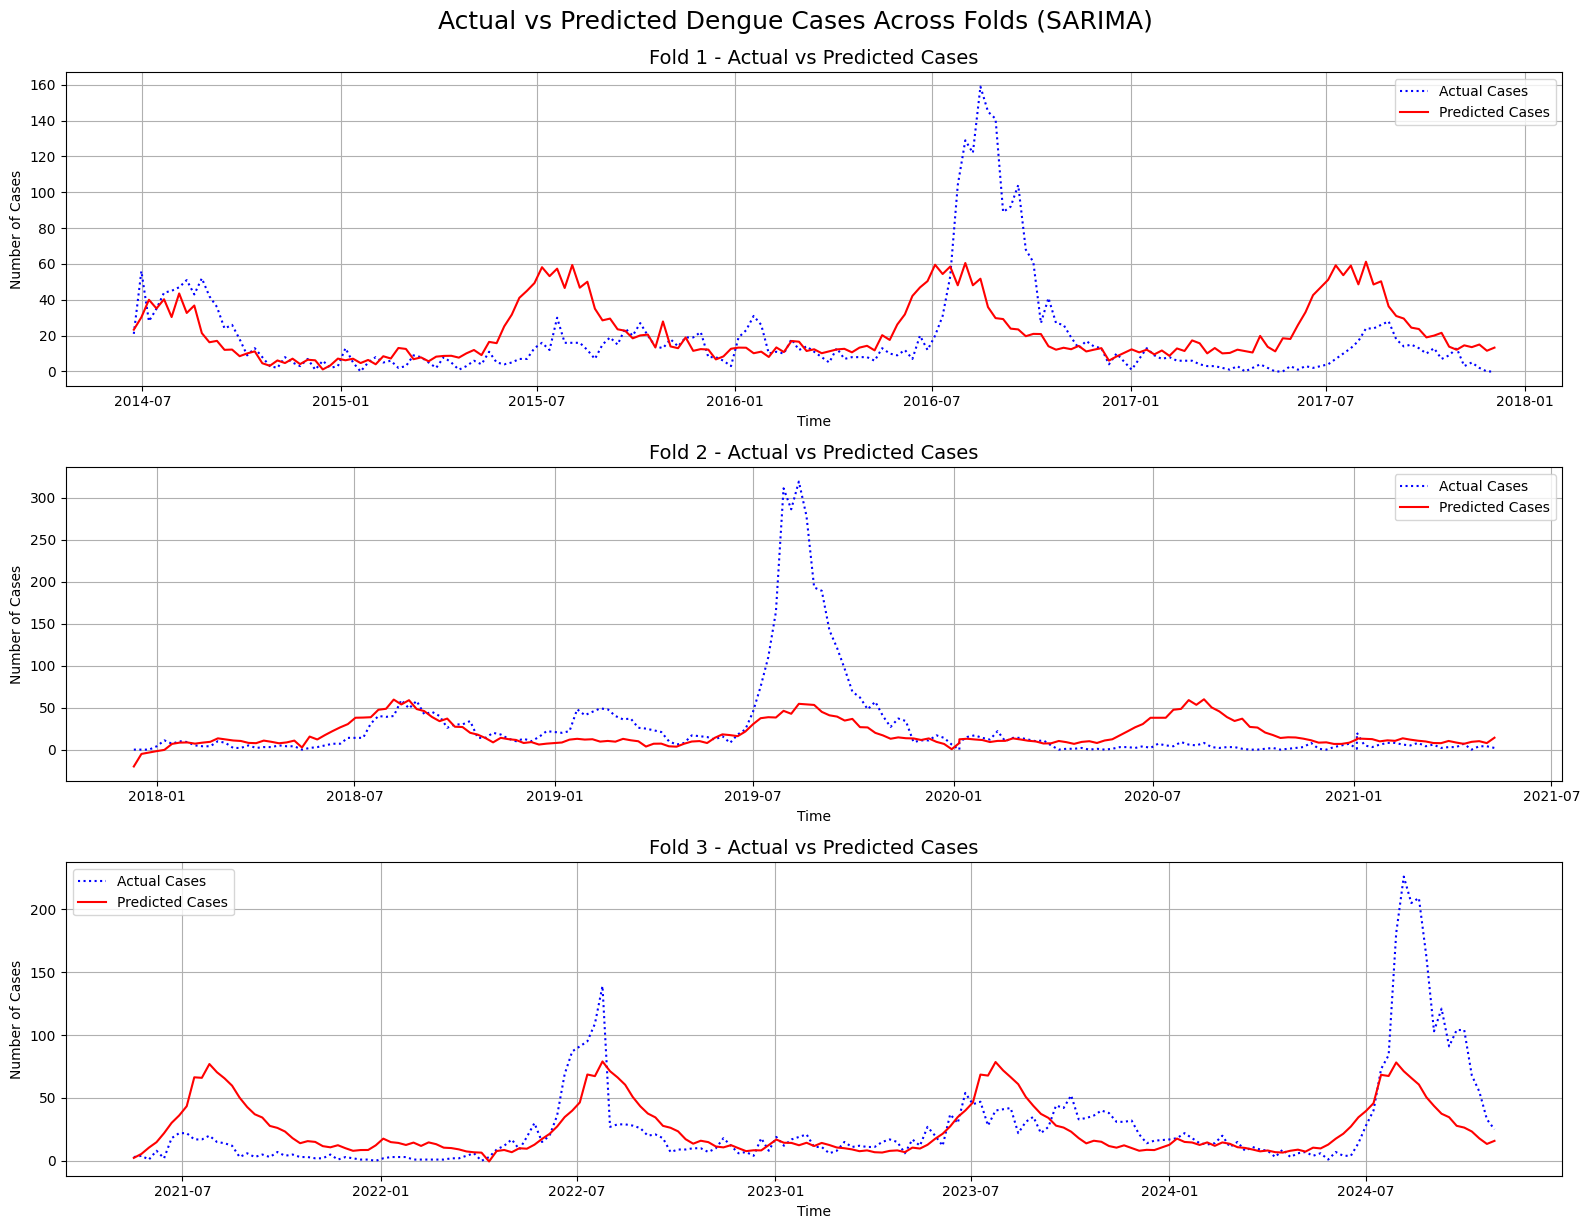


===== Fold Metrics Summary =====
   Fold          MSE       RMSE        MAE        R²
0     1   659.689788  25.684427  16.005345  0.095230
1     2  2127.490808  46.124731  21.309208  0.189176
2     3   996.438253  31.566410  18.899060  0.322853

===== Average Metrics Across 3 Folds =====
MSE     1261.206283
RMSE      34.458523
MAE       18.737871
R²         0.202419
dtype: float64


In [27]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define SARIMA parameters
order = (2, 0, 2)
seasonal_order = (0, 1, 1, 52)  # weekly seasonality for dengue cases

# Prepare dependent and independent variables
y = df['Cases']
X = df[['Rainfall', 'Temperature', 'Humidity']]

# Set up TimeSeriesSplit
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_results = []

# --- TIME SERIES CROSS VALIDATION ---
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\n===== Fold {fold + 1} =====")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    time_test = df['Time'].iloc[test_idx]

    # Define and fit SARIMA model
    model = SARIMAX(
        y_train, exog=X_train, order=order, seasonal_order=seasonal_order,
        enforce_stationarity=False, enforce_invertibility=False
    )
    model_fit = model.fit(method_kwargs={'maxiter': 400, 'disp': 0})

    # --- Forecast ---
    y_pred = model_fit.forecast(steps=len(y_test), exog=X_test)

    # --- Evaluation ---
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test MSE: {mse:.6f}")
    print(f"Test RMSE: {rmse:.6f}")
    print(f"Test MAE: {mae:.6f}")
    print(f"Test R²: {r2:.6f}")

    fold_results.append({
        'fold': fold + 1,
        'test_time': time_test.values,
        'y_test': y_test.values,
        'y_pred': y_pred.values,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
    })

# --- PLOTTING ---
plt.figure(figsize=(16, 4 * n_splits))

for i, result in enumerate(fold_results, 1):
    plt.subplot(n_splits, 1, i)
    plt.plot(result['test_time'], result['y_test'], label='Actual Cases', linestyle='dotted', color='blue')
    plt.plot(result['test_time'], result['y_pred'], label='Predicted Cases', color='red')
    plt.title(f"Fold {result['fold']} - Actual vs Predicted Cases", fontsize=14)
    plt.xlabel('Time')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.suptitle('Actual vs Predicted Dengue Cases Across Folds (SARIMA)', fontsize=18, y=1.02)
plt.show()

# --- SUMMARY TABLE ---
metrics_df = pd.DataFrame({
    'Fold': [res['fold'] for res in fold_results],
    'MSE': [res['mse'] for res in fold_results],
    'RMSE': [res['rmse'] for res in fold_results],
    'MAE': [res['mae'] for res in fold_results],
    'R²': [res['r2'] for res in fold_results],
})
print("\n===== Fold Metrics Summary =====")
print(metrics_df)

# --- AVERAGE METRICS ---
avg_metrics = metrics_df[['MSE', 'RMSE', 'MAE', 'R²']].mean()
print("\n===== Average Metrics Across 3 Folds =====")
print(avg_metrics)


 Evaluation (MSE, RMSE, R², Accuracy, Precision, Recall)

In [ ]:
# Check for NaN values in predictions
if predictions.isna().any():
    print("Predicted Cases contains NaN values. Check the model fit and the input data.")
else:
    # Calculate evaluation metrics
    mse = mean_squared_error(test['Cases'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test['Cases'], predictions)
    mae = mean_absolute_error(test['Cases'], predictions)

    # Set a threshold for binary classification (adjust based on your use case)
    threshold = 100  # Example threshold for "outbreak"
    actual_classes = np.where(test['Cases'] > threshold, 1, 0)
    predicted_classes = np.where(predictions > threshold, 1, 0)

    # Print evaluation results
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")


MSE: 1109.694860
RMSE: 33.312083
MAE: 18.085894


Actual vs Predicted Values

In [ ]:
results = pd.DataFrame({
    'Predicted Cases': predictions.values,
    'Actual Cases': test['Cases'].reset_index(drop=True)
})
results.head()

Predicted Cases  Actual Cases
0         3.256148             3
1         7.054910             1
2         5.937640             1
3        10.080613             1
4         9.692923             1

Display Plot

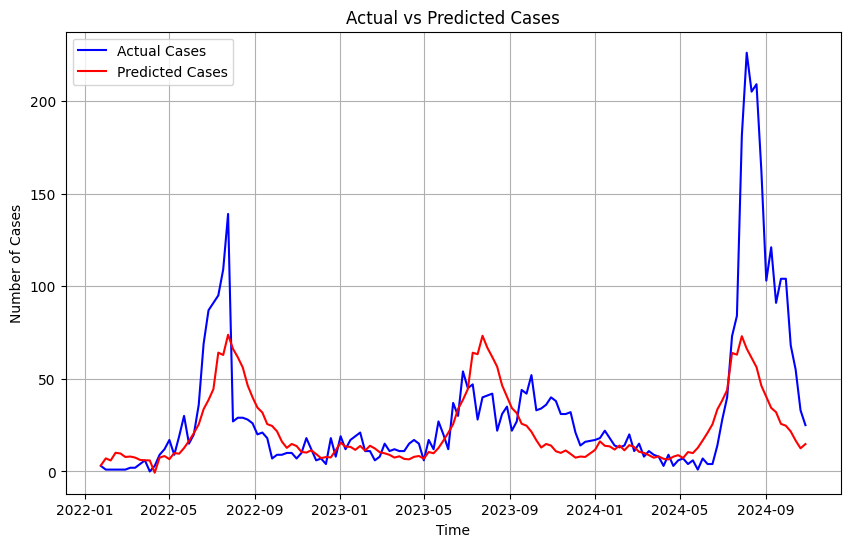

In [ ]:
# Plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test['Time'], test['Cases'], label='Actual Cases', color='blue')
plt.plot(test['Time'], predictions, label='Predicted Cases', color='red')
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.title('Actual vs Predicted Cases')
plt.legend()
plt.grid(True)
plt.show()
